# Problem Statement:                    

>>In this project we have to build a system which summarizes the customer reviews of a particular product into a bunch of keywords, so that when a customer goes to a product page, he/she doesn’t have to read long reviews. Instead he/she can make up his/her mind based on the product average rating and summarized keywords of the review.           

### DATA DESCRIPTION:                      
##### Features                                                                         
 IC – Item Code of the product, e.g. B016MF3P3K             
 Reviewer_Name - Name of the reviewer                        
 Useful- Number of useful votes (upvotes) of the review           
 Prod_meta- a dictionary of the product metadata. It contains only additional information about the product, if any available. 
 Review- text of the review                                            
 Rating- rating given to the product by the reviewer.              
 Rev_summ- summary of the review                                           
 Review_timestamp- time when the review has been posted (unix time format)                  
 Review_Date- Date when the review has been posted                       
 Prod_img- images that users post after they have received the product                   
 Rev_verify- Flag to represent whether the review has been verified or not. (True/False)           

In [2]:
# Importing useful libraries for topic modelling
import pandas as pd
import numpy as np
import string
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# packages from gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the json file in a DataFrame..
df_products = pd.read_json("Cell_Phones_and_Accessories.json")
df_products.head(10)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None
5,5,True,"12 22, 2016",B00MAWPGMI,{'Color:': ' _Shimmery White'},hannahv_tc,"Love this case, very sturdy!",Five Stars,1482364800,None,None
6,5,False,"08 1, 2016",B00NB7B4GI,None,Nadia,Simple and good quality iPhone 6 case. Fits on...,Simple and good quality iPhone 6 case,1470009600,None,None
7,5,True,"06 22, 2015",B00NMR6N7W,"{'Color:': ' Clear', 'Package Type:': ' Standa...",Jacob,Great screen protector for the money! Paid $1....,Perfect!,1434931200,None,None
8,5,True,"08 13, 2017",B018V60504,{'Color:': ' Black'},Metlman,"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,1502582400,None,None
9,5,False,"04 2, 2015",B00PG8TID6,"{'Color:': ' Black', 'Product Packaging:': ' S...",A. Burke,Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,1427932800,None,None


# EDA

In [4]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", df_products.columns)
shape=df_products.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", df_products.dtypes)
print("\nDataset contains any NaN/Empty cells : ", df_products.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", df_products.isnull().sum(),"\n\n")



Features Present in the Dataset: 
 Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

Total Number of Rows :  760450
Total Number of Features :  11


Data Types of Features :
 Rating               int64
Rev_verify            bool
Review_Date         object
IC                  object
Prod_meta           object
Reviewer_Name       object
Review              object
Rev_summ            object
Review_timestamp     int64
Useful              object
Prod_img            object
dtype: object

Dataset contains any NaN/Empty cells :  True

Total number of empty rows in each feature:
 Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352624
Reviewer_Name           91
Review                 530
Rev_summ               355
Review_timestamp         0
Useful              698250
Prod_img         

In [5]:
# An example of Information present in prod_meta feature..
a=list(df_products.Prod_meta[20].items())
print(a)
for i in range(0,len(a)):
    print(a[i][0])
    print(a[i][1])

[('Size:', ' Apple iPhone 5/5S'), ('Color:', ' Black/Black')]
Size:
 Apple iPhone 5/5S
Color:
 Black/Black


In [6]:
#  filling up the empty rows in the prod_meta feature with None values, 
#   as this feature tells us about the extra product information like (color, size etc..). 
df_products.Prod_meta.fillna("None",inplace=True)

In [7]:
# Here I am using the Prod_meta feature to get some useful information from it like (color, size etc..)...
size=[]
color=[]
for j,i in enumerate(df_products.Prod_meta[:]):
    if i=='None':
       ## append it as a none value
        pass
    else:
        #print(i,"\n\n")
        a=list(i.items())
        
        for k in range(0,len(a)):
            if a[k][0] =='Color:' or a[k][0] =='Color Name:':
                color.append(a[k][1])            
            elif a[k][0]=='Size:':                
                size.append(a[k][1])

        

     

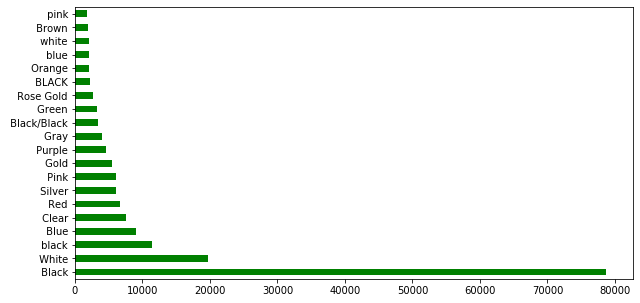

In [8]:
# Here I am plotting the favourite mobile colors among the people in the market... 
color=pd.DataFrame(color,columns=['Color'])
plt.subplots(figsize=(10,5))
color.Color.value_counts().head(20).plot(kind='barh',color='green')

In [9]:
# Showing the counts of the popular colors in demand in the market..
color.Color.value_counts().head(5)

 Black    78742
 White    19659
 black    11415
 Blue      9094
 Clear     7527
Name: Color, dtype: int64

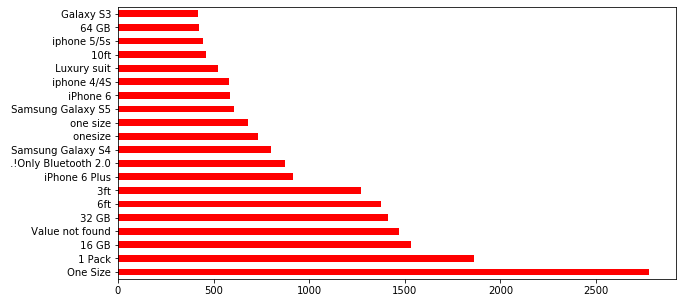

In [10]:
# Here I am plotting the most popular mobile size people prefer... 
size=pd.DataFrame(size,columns=['Size'])
plt.subplots(figsize=(10,5))
size.Size.value_counts().head(20).plot(kind='barh',color='red')

In [11]:
# Showing the counts of the popular feature/Size in demand in the market..
size.Size.value_counts().head(5)

 One Size           2779
 1 Pack             1862
 16 GB              1534
 Value not found    1469
 32 GB              1410
Name: Size, dtype: int64

In [12]:
# Droppping the features from which no more useful information can be gained for further processing...
df_products.drop(['Prod_meta','Prod_img','Reviewer_Name'],axis=1,inplace=True)

In [13]:
print("Total number of unique values in each feature:")

for col in df_products.columns.values:
    print("Number of unique values of {} : {}".format(col, df_products[col].nunique()))


Total number of unique values in each feature:
Number of unique values of Rating : 5
Number of unique values of Rev_verify : 2
Number of unique values of Review_Date : 4362
Number of unique values of IC : 48134
Number of unique values of Review : 637152
Number of unique values of Rev_summ : 366617
Number of unique values of Review_timestamp : 4362
Number of unique values of Useful : 386


In [14]:
# Considering only non null rows in the review feature...
df_products = df_products[df_products['Review'].notnull()]

In [15]:
# checking the shape after removing empty rows...
df_products.shape

(759920, 8)

In [16]:
# dropping the duplicate entries if any...
df_products.drop_duplicates(inplace=True)

In [17]:
# checking the shape after removing duplicate entries...
df_products.shape

(758147, 8)

In [18]:
# Checking Review date values...
df_products.Review_Date.head(10)

0     09 1, 2015
1     01 9, 2016
2    04 21, 2013
3    02 27, 2013
4    12 19, 2013
5    12 22, 2016
6     08 1, 2016
7    06 22, 2015
8    08 13, 2017
9     04 2, 2015
Name: Review_Date, dtype: object

**As we can see that in Review_date feature the dates are not in good format thus I will use Review_timestamp to get the dates in standard format...**

In [19]:
# Here I am using datetime in order to get dates from timestamp feature...
from datetime import datetime
condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df_products["Review_timestamp"] = df_products["Review_timestamp"].apply(condition)
df_products["Review_timestamp"].head(10)

0    09-01-2015
1    01-09-2016
2    04-21-2013
3    02-27-2013
4    12-19-2013
5    12-22-2016
6    08-01-2016
7    06-22-2015
8    08-13-2017
9    04-02-2015
Name: Review_timestamp, dtype: object

**Now The dates are in standard format...**

In [20]:
# Dropping Review_date feature in which dates are not in standard format....
df_products.drop(['Review_Date'],axis=1,inplace=True)

In [21]:
# Separating  review Dates into separate year,day and month features.... 
df_products["Day_of_Week"] = pd.to_datetime(df_products["Review_timestamp"], format = '%m-%d-%Y').dt.day_name()
df_products["Day_Of_review"] = pd.to_datetime(df_products["Review_timestamp"], format = '%m-%d-%Y').dt.day
df_products["Month_of_Review"] = pd.to_datetime(df_products["Review_timestamp"], format = '%m-%d-%Y').dt.month
df_products["Year_of_Review"] = pd.to_datetime(df_products["Review_timestamp"], format = '%m-%d-%Y').dt.year

In [22]:
# checking the new created features...
df_products.head(10)

,Rating,Rev_verify,IC,Review,Rev_summ,Review_timestamp,Useful,Day_of_Week,Day_Of_review,Month_of_Review,Year_of_Review
0,5,True,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,09-01-2015,None,Tuesday,1,9,2015
1,5,True,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,01-09-2016,None,Saturday,9,1,2016
2,5,True,B008DC8N5G,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,04-21-2013,None,Sunday,21,4,2013
3,3,True,B0089CH3TM,"The material and fit is very nice, but the col...",Good case overall,02-27-2013,3,Wednesday,27,2,2013
4,4,True,B00AKZWGAC,This last me about 3 days till i have to charg...,Awesome Battery,12-19-2013,None,Thursday,19,12,2013
5,5,True,B00MAWPGMI,"Love this case, very sturdy!",Five Stars,12-22-2016,None,Thursday,22,12,2016
6,5,False,B00NB7B4GI,Simple and good quality iPhone 6 case. Fits on...,Simple and good quality iPhone 6 case,08-01-2016,None,Monday,1,8,2016
7,5,True,B00NMR6N7W,Great screen protector for the money! Paid $1....,Perfect!,06-22-2015,None,Monday,22,6,2015
8,5,True,B018V60504,"Nice charger. One problem, one if the two USB ...",Make sure your Items work before you miss the ...,08-13-2017,None,Sunday,13,8,2017
9,5,False,B00PG8TID6,Most battery packs for iPhones come as a total...,This clever design combines a battery pack int...,04-02-2015,None,Thursday,2,4,2015


In [23]:
# Printing the counts and percentage of reviews for each year...
print('Count of Year of the reviews given:')
print(df_products.Year_of_Review.value_counts())
print('Percentage Year of the reviews given: \n',(df_products.Year_of_Review.value_counts()/len(df_products.Rating))*100)

Count of Year of the reviews given:
2015    217367
2016    210050
2014    124619
2017     89428
2013     58157
2018     28216
2012     18854
2011      6041
2010      2231
2009      1480
2008       937
2007       439
2006       209
2005        82
2004        26
2003         9
2002         2
Name: Year_of_Review, dtype: int64
Percentage Year of the reviews given: 
 2015    28.670825
2016    27.705709
2014    16.437314
2017    11.795602
2013     7.670940
2018     3.721706
2012     2.486853
2011     0.796811
2010     0.294270
2009     0.195213
2008     0.123591
2007     0.057904
2006     0.027567
2005     0.010816
2004     0.003429
2003     0.001187
2002     0.000264
Name: Year_of_Review, dtype: float64


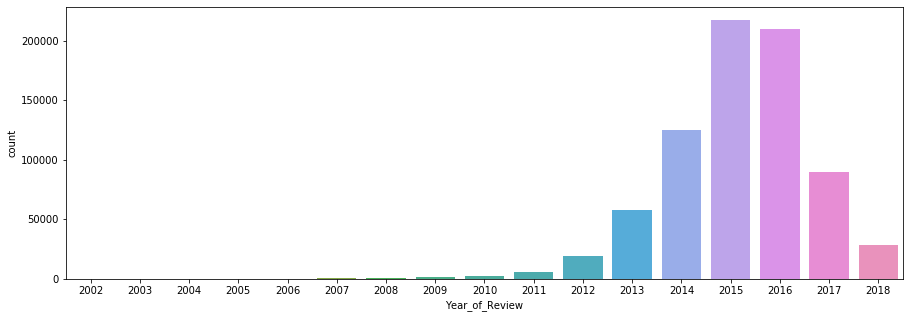

In [24]:
# Displaying number of reviews per year...
plt.subplots(figsize=(15,5))
sns.countplot(data=df_products,x='Year_of_Review')
plt.show()

**Maximum number of reviws were in year 2015,It maybe due to the government encouraging people to move towards digitalization**

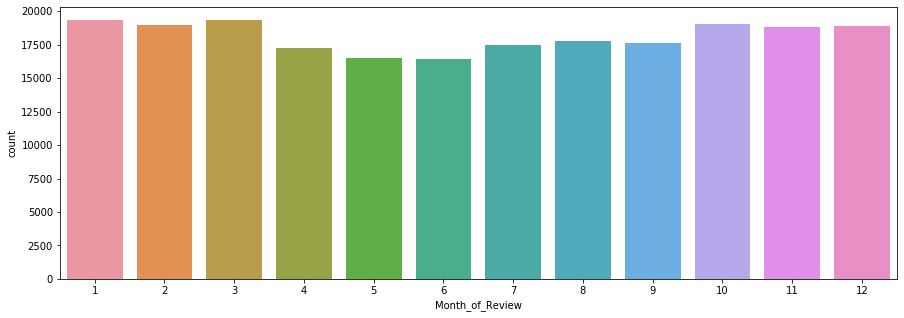

In [25]:
# Displaying number of reviews per month in year 2015 in which maximum reviews were uploaded by the customers...
plt.subplots(figsize=(15,5))
sns.countplot(data=df_products[df_products['Year_of_Review']==2015],x='Month_of_Review')
plt.show()

**First and last three months of year 2015 have more reviews rather than the rest.**

count of the Verified and Unverified reviews
True     663507
False     94640
Name: Rev_verify, dtype: int64
Percentage of the Verified and Unverified reviews:
 True     87.516933
False    12.483067
Name: Rev_verify, dtype: float64


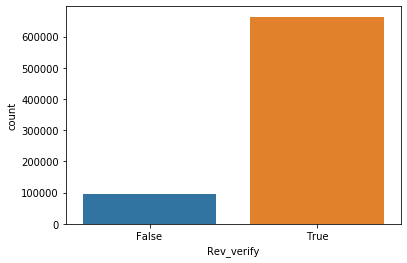

In [26]:
# Printing the counts and percentage of verified and unverified reviews...
print('count of the Verified and Unverified reviews')
print(df_products.Rev_verify.value_counts())
print('Percentage of the Verified and Unverified reviews:\n',(df_products.Rev_verify.value_counts()/len(df_products.Rev_verify))*100)

# Displaying counts of verified and unverified reviews...
sns.countplot(data=df_products,x='Rev_verify')
plt.show()

Count of the ratings:
5    475201
4    123562
3     66201
1     54804
2     38379
Name: Rating, dtype: int64
Percentage of the  ratings: 
 5    62.679269
4    16.297895
3     8.731948
1     7.228677
2     5.062211
Name: Rating, dtype: float64


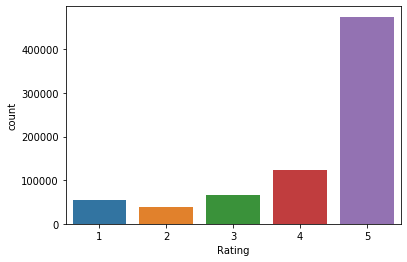

In [27]:
# Printing the counts and percentage of ratings provided to the products...
print('Count of the ratings:')
print(df_products.Rating.value_counts())
print('Percentage of the  ratings: \n',(df_products.Rating.value_counts()/len(df_products.Rating))*100)

# Displaying counts of ratings provided to the products...
sns.countplot(data=df_products,x='Rating')
plt.show()

### Ratings Exploration:

In [28]:
# Exploring Ratings in order to get values for average rating, minimum ratings, maximum ratings and total ratings 
#  for each product...

# Average rating for each product:
average_rating = round(df_products.groupby(['IC'])['Rating'].mean().reset_index(),1)

# Minimum ratings for each product:
minimum_rating = df_products.groupby(['IC'])['Rating'].min().reset_index()

# Maximum ratings for each product:
maximum_rating = df_products.groupby(['IC'])['Rating'].max().reset_index()

# Total ratings for each product:
total_ratings = df_products.groupby(['IC'])['Rating'].count().reset_index()


In [29]:
# Thus the length of the rating is same as that of the overall produts... i.e 48133 
total_ratings.shape

(48133, 2)

In [30]:
# Finding out the number of counts of rating given to a particular product
one_star= df_products[df_products['Rating']==1].groupby(['IC'])['Rating'].count().reset_index()
two_star = df_products[df_products['Rating']==2].groupby(['IC'])['Rating'].count().reset_index()
three_star = df_products[df_products['Rating']==3].groupby(['IC'])['Rating'].count().reset_index()
four_star= df_products[df_products['Rating']==4].groupby(['IC'])['Rating'].count().reset_index()
five_star= df_products[df_products['Rating']==5].groupby(['IC'])['Rating'].count().reset_index()

In [31]:
# We can see that the length of the four star rating is small than the length of the products that is because:
# "Not all the products can get four star rating thus rest values would be empty , those would be filled by 0 rating..." .
# one star, two star , threee star and five star also had some different lengths all those will be filled by 0 rating in next step.
four_star.shape

(34398, 2)

In [32]:
# Creating a DataFrame in order to show all the Ratings Information in a single place...
Ratings=pd.DataFrame(data={'Product_ID':average_rating.IC,'Average_rating':average_rating.Rating,'Minimum_ratings':minimum_rating.Rating,'Maximum_rating':maximum_rating.Rating,'ONE_Star_Rating':one_star.Rating,'TWO_Star_Rating':two_star.Rating,'THREE_Star_Rating':three_star.Rating,'FOUR_Star_Rating':four_star.Rating,'FIVE_Star_Rating':five_star.Rating,'Total_ratings':total_ratings.Rating})
Ratings.fillna(0,inplace=True)

In [33]:
# converting float values into int values 
for col in Ratings.select_dtypes(include=['float']).columns:
             Ratings[col] = Ratings[col].astype(int)

In [34]:
# Printing few samples to verify...
Ratings.sample(10)

,Product_ID,Average_rating,Minimum_ratings,Maximum_rating,ONE_Star_Rating,TWO_Star_Rating,THREE_Star_Rating,FOUR_Star_Rating,FIVE_Star_Rating,Total_ratings
39964,B017JT6846,4,1,5,0,0,0,0,5,141
23057,B00MIG3TMK,3,2,5,0,0,1,1,2,7
30495,B00U0WQ9G2,3,1,5,0,0,0,5,83,11
21892,B00LGY7J6C,5,5,5,1,0,4,1,2,3
19343,B00JH82T0K,3,1,5,1,0,1,3,23,38
637,B00170I3ME,3,1,5,1,5,1,2,2,4
17817,B00I8LBDRM,4,3,5,1,1,9,2,5,4
10773,B00BUUIOS4,4,1,5,1,1,2,2,3,31
47777,B01H1H40VO,4,3,5,0,0,0,0,0,3
38532,B015WB9D7W,3,1,5,0,0,0,0,2,2


In [35]:
# saving the product and their ratings data in a csv file
Ratings.to_csv("Product_and_Ratings.csv")

# Data Cleaning and Preprocessing:

In [36]:
# Filling up empty values in Rev_summ by a white space as this will be joined with reviews to get some useful information...
df_products["Rev_summ"].fillna(" ", inplace = True) 

In [37]:
# Joining reviews and Review summary an dsaving it in a single feature...
df_products['Full_review']=df_products.Review+' '+df_products.Rev_summ

In [38]:
# Finding out the length of the review after joining with the review summary
df_products["Full_review_length"] = df_products.Full_review.str.len()
df_products

,Rating,Rev_verify,IC,Review,Rev_summ,Review_timestamp,Useful,Day_of_Week,Day_Of_review,Month_of_Review,Year_of_Review,Full_review,Full_review_length
0,5,True,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,09-01-2015,None,Tuesday,1,9,2015,Bought it for my husband. He's very happy with...,70
1,5,True,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,01-09-2016,None,Saturday,9,1,2016,Great screen protector. Doesn't even seem as ...,77
2,5,True,B008DC8N5G,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,04-21-2013,None,Sunday,21,4,2013,Saved me lots of money! it's not gorilla glass...,323
3,3,True,B0089CH3TM,"The material and fit is very nice, but the col...",Good case overall,02-27-2013,3,Wednesday,27,2,2013,"The material and fit is very nice, but the col...",127
4,4,True,B00AKZWGAC,This last me about 3 days till i have to charg...,Awesome Battery,12-19-2013,None,Thursday,19,12,2013,This last me about 3 days till i have to charg...,484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
760445,4,False,B00C3V9M8A,Very good,Four Stars,07-12-2014,None,Saturday,12,7,2014,Very good Four Stars,20
760446,5,False,B0178BYS24,My name is Cynthia Beard and I believe that th...,... believe that the Samsung Galaxy car mount ...,07-13-2016,None,Wednesday,13,7,2016,My name is Cynthia Beard and I believe that th...,436
760447,4,True,B009KY47CE,This iphone case is very durable and long last...,I LOVE THIS,07-23-2015,None,Thursday,23,7,2015,This iphone case is very durable and long last...,82
760448,5,True,B00X60AYDY,great,Five Stars,12-14-2015,None,Monday,14,12,2015,great Five Stars,16


In [39]:
# joining all the reviews  for a particular product...
df_product_review = df_products.groupby(['IC'])['Full_review'].apply('. '.join).reset_index()

In [40]:
# finding length of the full reviews....
df_product_review["Full_review_length"] = df_products.Full_review.str.len()

In [41]:
# finding length of the Combined  reviews....
df_product_review["combined_reviews_length"] = df_product_review.Full_review.str.len()

In [42]:
# It is clear that the reviews are combined successfully as we can see that legth is increased... 
df_product_review

,IC,Full_review,Full_review_length,combined_reviews_length
0,7508492919,It is such a good case for a low price. I have...,70.0,7693
1,7532385086,I was very excited when I first got this case....,77.0,1151
2,7887421268,Good item Five Stars. Received this in about a...,323.0,2035
3,8199900164,thank you. Five Stars. Works some of the time....,127.0,309
4,8288853439,Great ! So far.\nI had this charger before and...,484.0,2410
...,...,...,...,...
48128,B01HJBS5C2,"Strong, protective but slim and light. I am al...",271.0,3323
48129,B01HJC7N4C,my sons likes it. For the price it isn't too b...,20.0,5018
48130,B01HJCN1UC,great thanks Five Stars. good cable. just be s...,154.0,3874
48131,B01HJCN55I,Received the cable in two days and it's the be...,244.0,1632


**Preprocessing the raw text:         
This involves the following:         
1) Tokenization: Split the text words. Lowercase the words and remove punctuation.        
2) All the numbers, emails, are removed as they are not needed here.       
3) All stopwords are removed.           
4) Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.                                               
5) All the special characters are removed.        
6) All the extra whitespaces are removed.              
7) Pos tagging is used for better token selection**          

In [44]:
#     Here I have made a function in which all the Data cleaning steps like removing data which is not useful like 
#       email adress, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization technique, filtering documents using Stopwords,using POS tagging,
#      all these type of data preprocessing steps are being perormed with th ehelp of the function defined below.

# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning...
def Processed_data(reviews):
    # Replace email addresses with 'email'
    review=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', reviews)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    review=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',review)
    
    # Replace numbers with 'numbr'
    review=re.sub(r'\d+(\.\d+)?', ' ', review)
        
    # getting only words(i.e removing all the special characters)
    review = re.sub(r'[^\w]', ' ', review) 
        
    # getting only words(i.e removing all the" _ ")
    review = re.sub(r'[\_]', ' ', review) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    review=re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    
    # Removing extra whitespaces
    review=re.sub(r'\s+', ' ', review, flags=re.I)

    #converting all the letters of the review into lowercase
    review = review.lower()
    
    # splitting every words from the sentences
    review = review.split()

    # iterating through each words and checking if they are stopwords or not,
    review=[word for word in review if not word in set(STOPWORDS)]
    
    # remove empty tokens
    review = [text for text in review if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(review)

    # considering words having length more than 3only
    review = [text for text in review if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    review = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    review = [text for text in review if len(text) > 3]
    review = ' '.join(review)
    return review

In [45]:
# cleaning the reviews and storing them in a separate feature...
df_product_review["Full_review_clean"] = df_product_review["Full_review"].apply(lambda x: Processed_data(x))

In [46]:
# Printing first few rows...
df_product_review.head(10)

,IC,Full_review,Full_review_length,combined_reviews_length,Full_review_clean
0,7508492919,It is such a good case for a low price. I have...,70.0,7693,good case price right problem losing stone pur...
1,7532385086,I was very excited when I first got this case....,77.0,1151,excited case loved color feel started noticing...
2,7887421268,Good item Five Stars. Received this in about a...,323.0,2035,good item star received week time nice actuall...
3,8199900164,thank you. Five Stars. Works some of the time....,127.0,309,thank star work time charger stopped working s...
4,8288853439,Great ! So far.\nI had this charger before and...,484.0,2410,great charger pretty good year phone iphone ga...
5,8288862993,"OEM is the way to go, fits the way it should a...",39.0,5474,short definately recommend price right charger...
6,828886922X,Perfect to use on my note 4. I got this as an ...,178.0,1427,perfect note backup charger chages samsung nit...
7,8288878881,This charger specifically didn't last that lon...,356.0,7122,charger specifically long term usage plugged r...
8,9578085451,Nice case but print started to fade and peel a...,441.0,1196,nice case print started fade peel star bought ...
9,961301375X,Finally...one that actually works in my car fo...,1618.0,1707,finally actually work samsung note charge fast...


In [47]:
# Calculating cleaned reviews length
df_product_review['Proccessed_review_length']=df_product_review['Full_review_clean'].str.len()

In [48]:
# Printing first few rows...
df_product_review.head(10)

,IC,Full_review,Full_review_length,combined_reviews_length,Full_review_clean,Proccessed_review_length
0,7508492919,It is such a good case for a low price. I have...,70.0,7693,good case price right problem losing stone pur...,3594
1,7532385086,I was very excited when I first got this case....,77.0,1151,excited case loved color feel started noticing...,591
2,7887421268,Good item Five Stars. Received this in about a...,323.0,2035,good item star received week time nice actuall...,1032
3,8199900164,thank you. Five Stars. Works some of the time....,127.0,309,thank star work time charger stopped working s...,134
4,8288853439,Great ! So far.\nI had this charger before and...,484.0,2410,great charger pretty good year phone iphone ga...,1173
5,8288862993,"OEM is the way to go, fits the way it should a...",39.0,5474,short definately recommend price right charger...,2796
6,828886922X,Perfect to use on my note 4. I got this as an ...,178.0,1427,perfect note backup charger chages samsung nit...,693
7,8288878881,This charger specifically didn't last that lon...,356.0,7122,charger specifically long term usage plugged r...,3616
8,9578085451,Nice case but print started to fade and peel a...,441.0,1196,nice case print started fade peel star bought ...,531
9,961301375X,Finally...one that actually works in my car fo...,1618.0,1707,finally actually work samsung note charge fast...,945


In [50]:
# Using Spacy to find out the Important keywords for different reviews for each product...
import spacy
"""Load the pre-trained NLP model in spacy"""
nlp=spacy.load("en_core_web_lg") 


"""Define a function to extract keywords"""
def get_keywords(x):
    doc=nlp(x) ## Tokenize and extract grammatical components
    doc=[i.text for i in doc if i.pos_=="NOUN" ] ## Retaining only nouns
    doc=pd.Series(doc)
    doc=doc.value_counts().head(15).index.tolist() ## Get 15 most frequent nouns
    return doc

df_product_review["Keyword_Summary"] = df_product_review["Full_review_clean"].apply(lambda x: get_keywords(x))

In [52]:
df_product_review

,IC,Full_review,Full_review_length,combined_reviews_length,Full_review_clean,Proccessed_review_length,Keyword_Summary
0,7508492919,It is such a good case for a low price. I have...,70.0,7693,good case price right problem losing stone pur...,3594,"[case, phone, love, time, bling, stone, price,..."
1,7532385086,I was very excited when I first got this case....,77.0,1151,excited case loved color feel started noticing...,591,"[phone, case, product, money, refund, look, co..."
2,7887421268,Good item Five Stars. Received this in about a...,323.0,2035,good item star received week time nice actuall...,1032,"[case, phone, product, deal, price, protection..."
3,8199900164,thank you. Five Stars. Works some of the time....,127.0,309,thank star work time charger stopped working s...,134,"[work, phone, beep, charger, time, item, star,..."
4,8288853439,Great ! So far.\nI had this charger before and...,484.0,2410,great charger pretty good year phone iphone ga...,1173,"[charger, work, phone, price, charge, problem,..."
...,...,...,...,...,...,...,...
48128,B01HJBS5C2,"Strong, protective but slim and light. I am al...",271.0,3323,strong protective slim light ordering type cas...,1748,"[case, phone, belt, clip, holster, protection,..."
48129,B01HJC7N4C,my sons likes it. For the price it isn't too b...,20.0,5018,like price star recently received free sample ...,2507,"[headset, device, apps, phone, glass, review, ..."
48130,B01HJCN1UC,great thanks Five Stars. good cable. just be s...,154.0,3874,great thanks star good cable sure know length ...,2035,"[cord, cable, length, love, charge, charger, s..."
48131,B01HJCN55I,Received the cable in two days and it's the be...,244.0,1632,received cable best cable recharging kindle fe...,782,"[cable, work, time, length, issue, star, cord,..."


In [54]:
# Making a new feature to distinguish positive and negative sentiments on the basis of average rating of the product...
li=[]
for i in Ratings["Average_rating"]:
    if i>=3:
        li.append('Positive')
    elif i<3:
        li.append("Negative")
        
Ratings["Sentiment_review"] = li

In [55]:
# checking the new feature...
Ratings.head(15)

,Product_ID,Average_rating,Minimum_ratings,Maximum_rating,ONE_Star_Rating,TWO_Star_Rating,THREE_Star_Rating,FOUR_Star_Rating,FIVE_Star_Rating,Total_ratings,Sentiment_review
0,7508492919,4,1,5,1,1,4,13,21,40,Positive
1,7532385086,3,1,5,2,1,1,2,2,7,Positive
2,7887421268,3,1,5,3,1,1,2,6,13,Positive
3,8199900164,3,2,5,2,1,1,2,2,4,Positive
4,8288853439,3,1,5,6,3,2,6,6,11,Positive
5,8288862993,3,1,5,6,2,1,2,15,32,Positive
6,828886922X,4,3,5,3,1,5,5,3,6,Positive
7,8288878881,4,1,5,4,2,1,1,26,44,Positive
8,9578085451,4,3,5,2,5,1,2,2,4,Positive
9,961301375X,3,1,5,5,1,1,3,8,13,Positive


Count of the Postive and Negative reviews:
Positive    46186
Negative     1947
Name: Sentiment_review, dtype: int64
Percentage of the Positive and Negative reviews:
 Positive    95.954958
Negative     4.045042
Name: Sentiment_review, dtype: float64


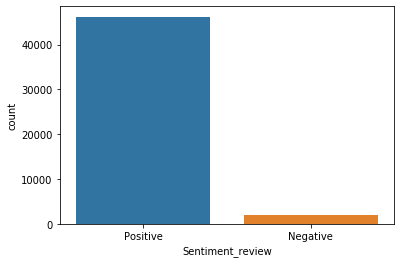

In [56]:
# Displaying Positive and Negative reviews based on average product rating...
print('Count of the Postive and Negative reviews:')
print(Ratings.Sentiment_review.value_counts())

print('Percentage of the Positive and Negative reviews:\n',(Ratings.Sentiment_review.value_counts()/len(Ratings.Sentiment_review))*100)

sns.countplot(data=Ratings,x='Sentiment_review')
plt.show()

In [57]:
# Making a new dataframe to store product id and keywords...
final_df=pd.DataFrame(data={'Product_ID':df_product_review.IC,'Keyword_Summary':df_product_review.Keyword_Summary})
final_df.head()

,Product_ID,Keyword_Summary
0,7508492919,"[case, phone, love, time, bling, stone, price,..."
1,7532385086,"[phone, case, product, money, refund, look, co..."
2,7887421268,"[case, phone, product, deal, price, protection..."
3,8199900164,"[work, phone, beep, charger, time, item, star,..."
4,8288853439,"[charger, work, phone, price, charge, problem,..."


In [58]:
# Merging the dataframe final_df and Ratings so that all the important information regarding the Product is present at a single place
output_final_df=pd.merge(Ratings, final_df, how ='inner', on ='Product_ID')
output_final_df.head(10)

,Product_ID,Average_rating,Minimum_ratings,Maximum_rating,ONE_Star_Rating,TWO_Star_Rating,THREE_Star_Rating,FOUR_Star_Rating,FIVE_Star_Rating,Total_ratings,Sentiment_review,Keyword_Summary
0,7508492919,4,1,5,1,1,4,13,21,40,Positive,"[case, phone, love, time, bling, stone, price,..."
1,7532385086,3,1,5,2,1,1,2,2,7,Positive,"[phone, case, product, money, refund, look, co..."
2,7887421268,3,1,5,3,1,1,2,6,13,Positive,"[case, phone, product, deal, price, protection..."
3,8199900164,3,2,5,2,1,1,2,2,4,Positive,"[work, phone, beep, charger, time, item, star,..."
4,8288853439,3,1,5,6,3,2,6,6,11,Positive,"[charger, work, phone, price, charge, problem,..."
5,8288862993,3,1,5,6,2,1,2,15,32,Positive,"[charger, phone, work, cord, product, price, s..."
6,828886922X,4,3,5,3,1,5,5,3,6,Positive,"[charger, cord, company, phone, work, base, st..."
7,8288878881,4,1,5,4,2,1,1,26,44,Positive,"[phone, charger, work, product, star, charge, ..."
8,9578085451,4,3,5,2,5,1,2,2,4,Positive,"[case, phone, price, plug, cutout, fall, month..."
9,961301375X,3,1,5,5,1,1,3,8,13,Positive,"[charger, charge, work, phone, star, junk, not..."


In [59]:
# Converting and saving the dataframe having all imp information regarding product in a json file...
output_final_df.to_json('Cell_Phones_and_Accessories_Products_keywords.json')